In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import fasttext
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Check for GPU availability
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download NLTK resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rizvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Custom Dataset


In [3]:
class BanglaDataset(Dataset):
    def __init__(self, df, max_seq_len=50, fasttext_model=None):
        self.df = df
        self.nsamples = len(self.df)
        self.fasttext_model = fasttext_model  # FastText model
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        review = self.df.iloc[index]['clean_sentence']
        sentiment = self.df.iloc[index]['Sentiment']

        word_list = word_tokenize(review)
        x = []
        for w in word_list:
            w = w.lower()
            # Get the vector from the FastText model
            x.append(self.fasttext_model.get_word_vector(w))

        # Convert to 2D array if not empty
        if len(x) > 0:
            x = np.array(x)
        else:
            x = np.zeros((self.max_seq_len, 300))  # Ensure x is padded even if empty

        # Truncate if greater than max len
        x = x[:self.max_seq_len]
        # Padding if less than max len
        padding_len = self.max_seq_len - x.shape[0]
        padding = np.zeros((padding_len, 300))  # Padding should match the embedding dimension
        x = np.concatenate((x, padding), axis=0)

        y = sentiment

        x = torch.FloatTensor(x)
        y = torch.LongTensor([y])  # Use LongTensor for class labels

        return x, y

    def __len__(self):
        return self.nsamples

In [4]:
# Load FastText model
fasttext_model = fasttext.load_model(r'E:\Bangla-Sentiment-Analysis\Word Embeddings\cc.bn.300.bin')

# Model

In [5]:
class LSTM_Model(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes=3, bidirectional=True, dropout_rate=0.5):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout_rate)
        if bidirectional:
            self.fc = nn.Linear(hidden_dim * 2, num_classes)
        else:
            self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        if self.bidirectional:
            hn = torch.cat((hn[-2], hn[-1]), dim=1)  # final forward and backward states
        else:
            hn = hn.squeeze(0)
        hn = self.dropout(hn)  # dropout
        pred = self.fc(hn)
        return pred

# Initialize loss function
loss_fn = nn.CrossEntropyLoss()

# Load Dataset

In [6]:
train_val_df = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\train_val_data_df.xlsx') 
test_df = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\test_data_df.xlsx')

# Convert Sentiments to numeric labels
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
train_val_df['Sentiment'] = train_val_df['Sentiment'].map(sentiment_mapping)

sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
test_df['Sentiment'] = test_df['Sentiment'].map(sentiment_mapping)

In [7]:
# K-Fold Cross Validation
kf = KFold(n_splits=8, shuffle=True, random_state=42)
fold = 0

# To store metrics and losses for each fold
all_fold_metrics = []
all_fold_train_losses = []
all_fold_val_losses = []
best_fold_index = -1
best_val_loss_overall = float('inf')

# Train Model

In [8]:
for train_index, val_index in kf.split(train_val_df):
    fold += 1
    model = LSTM_Model(embedding_dim=300, hidden_dim=64, num_classes=3, bidirectional=True, dropout_rate=0.2)
    model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    print(f"\nStarting Fold {fold}")
    train_data = train_val_df.iloc[train_index]
    val_data = train_val_df.iloc[val_index]

    # Initialize datasets
    train_dataset = BanglaDataset(train_data, fasttext_model=fasttext_model)
    validation_dataset = BanglaDataset(val_data, fasttext_model=fasttext_model)

    # Create dataloaders
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=8, shuffle=True, num_workers=0)

    # Train the model
    nepoch = 10
    fold_train_loss = []
    fold_val_loss = []

    best_val_loss = float('inf')
    best_metrics = {'accuracy': 0, 'f_score': 0, 'precision': 0, 'recall': 0, 'best_epoch': 0}

    for i in range(nepoch):
        print(f"\nEpoch {i + 1}:")

        # --- Training ---
        model.train()
        tr_loss, n_tr_steps = 0., 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(DEVICE) for t in batch)
            (x, y) = batch

            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y.view(-1))
            tr_loss += loss.item()
            n_tr_steps += 1

            loss.backward()
            optimizer.step()

        mean_train_loss = tr_loss / n_tr_steps
        fold_train_loss.append(mean_train_loss)

        # --- Validation ---
        model.eval()
        val_loss, n_val_steps = 0., 0
        predictions, labels = [], []
        with torch.no_grad():
            for step, batch in enumerate(validation_dataloader):
                batch = tuple(t.to(DEVICE) for t in batch)
                (x, y) = batch
                out = model(x)
                loss = loss_fn(out, y.view(-1))
                val_loss += loss.item()
                n_val_steps += 1

                # Collect predictions
                preds = torch.argmax(out, dim=1)
                predictions += preds.cpu().numpy().tolist()
                labels += y.cpu().numpy().tolist()

        mean_val_loss = val_loss / n_val_steps
        fold_val_loss.append(mean_val_loss)

        # --- Calculate Metrics ---
        accuracy = accuracy_score(labels, predictions)
        f_score = f1_score(labels, predictions, average="weighted")
        precision = precision_score(labels, predictions, average="weighted")
        recall = recall_score(labels, predictions, average="weighted")

        # Print metrics for the current epoch
        print(f'Train Loss: {mean_train_loss:.4f}, Validation Loss: {mean_val_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}, F Score: {f_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Store best metrics for this fold
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_metrics = {
                'best_epoch': i + 1,  # Store 1-based index for epoch
                'accuracy': accuracy,
                'f_score': f_score,
                'precision': precision,
                'recall': recall,
                'train_loss': mean_train_loss,  # Store best train loss
                'val_loss': mean_val_loss       # Store best validation loss
            }
            # Save the model weights of the best epoch in this fold
            torch.save(model.state_dict(), f"best_fasttext_bilstm_model_fold_{fold}.pt")

    # Store losses for this fold
    all_fold_train_losses.append(fold_train_loss)
    all_fold_val_losses.append(fold_val_loss)

    # Store metrics for this fold
    all_fold_metrics.append(best_metrics)

    # Track the best fold based on validation loss
    if best_val_loss < best_val_loss_overall:
        best_val_loss_overall = best_val_loss
        best_fold_index = fold - 1  # Store the fold index (0-based)

    # After the fold training is complete
    print(f"\nBest Metrics for Fold {fold}:")
    print(f"Best Epoch: {best_metrics['best_epoch']}")
    print(f"Train Loss: {best_metrics['train_loss']:.4f}, Validation Loss: {best_metrics['val_loss']:.4f}")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}, F Score: {best_metrics['f_score']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}, Recall: {best_metrics['recall']:.4f}")


Starting Fold 1

Epoch 1:
Train Loss: 0.8702, Validation Loss: 0.8368
Accuracy: 0.6474, F Score: 0.5894, Precision: 0.6175, Recall: 0.6474

Epoch 2:
Train Loss: 0.7891, Validation Loss: 0.7711
Accuracy: 0.6759, F Score: 0.6546, Precision: 0.6526, Recall: 0.6759

Epoch 3:
Train Loss: 0.7567, Validation Loss: 0.7683
Accuracy: 0.6761, F Score: 0.6348, Precision: 0.6471, Recall: 0.6761

Epoch 4:
Train Loss: 0.7342, Validation Loss: 0.7613
Accuracy: 0.6736, F Score: 0.6615, Precision: 0.6557, Recall: 0.6736

Epoch 5:
Train Loss: 0.7127, Validation Loss: 0.7925
Accuracy: 0.6641, F Score: 0.6339, Precision: 0.6383, Recall: 0.6641

Epoch 6:
Train Loss: 0.6911, Validation Loss: 0.7630
Accuracy: 0.6776, F Score: 0.6563, Precision: 0.6522, Recall: 0.6776

Epoch 7:
Train Loss: 0.6722, Validation Loss: 0.7670
Accuracy: 0.6782, F Score: 0.6541, Precision: 0.6493, Recall: 0.6782

Epoch 8:
Train Loss: 0.6521, Validation Loss: 0.7810
Accuracy: 0.6693, F Score: 0.6628, Precision: 0.6589, Recall: 0.6693


--------------------------------------------------Best Fold Summary---------------------------------------------------------------------------
Best Fold: 2
Best Epoch: 6
Train Loss: 0.6967
Validation Loss: 0.7446
Accuracy: 0.6839
F Score: 0.6552
Precision: 0.6545
Recall: 0.6839


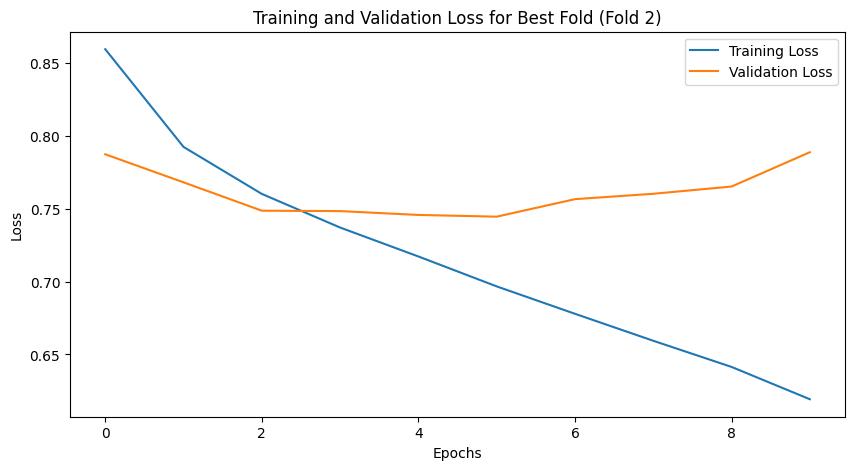

In [9]:
# Print the best fold details
print("\n--------------------------------------------------Best Fold Summary---------------------------------------------------------------------------")

best_fold_metrics = all_fold_metrics[best_fold_index]  # Retrieve the metrics of the best fold

# Print the metrics for the best fold
print(f"Best Fold: {best_fold_index + 1}")
print(f"Best Epoch: {best_fold_metrics['best_epoch']}")
print(f"Train Loss: {best_fold_metrics['train_loss']:.4f}")
print(f"Validation Loss: {best_fold_metrics['val_loss']:.4f}")
print(f"Accuracy: {best_fold_metrics['accuracy']:.4f}")
print(f"F Score: {best_fold_metrics['f_score']:.4f}")
print(f"Precision: {best_fold_metrics['precision']:.4f}")
print(f"Recall: {best_fold_metrics['recall']:.4f}")

# Retrieve the best fold's train and validation loss
best_fold_train_loss = all_fold_train_losses[best_fold_index]
best_fold_val_loss = all_fold_val_losses[best_fold_index]

# Plot the best fold's training and validation loss
plt.figure(figsize=(10, 5))
plt.title(f"Training and Validation Loss for Best Fold (Fold {best_fold_index + 1})")
plt.plot(best_fold_train_loss, label="Training Loss")
plt.plot(best_fold_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test Model

In [10]:
print("\n--------------------------------------------------Test Set---------------------------------------------------------------------------")

# After all folds, use the best model (based on validation loss) to evaluate the test dataset
print("\nEvaluating on Test Dataset")

# Prepare the test dataset and dataloader
test_dataset = BanglaDataset(test_df, fasttext_model=fasttext_model)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, num_workers=0)


# Load the best model's saved weights for the best fold (use the fold with best validation performance)
best_fold_model = LSTM_Model(embedding_dim=300, hidden_dim=64, num_classes=3, bidirectional=True, dropout_rate=0.5)
best_fold_model.load_state_dict(torch.load(f"best_fasttext_bilstm_model_fold_{best_fold_index + 1}.pt"))
best_fold_model.to(DEVICE)

# Move to GPU and evaluate on the test dataset
best_fold_model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(DEVICE) for t in batch)
        (x, y) = batch
        out = best_fold_model(x)
        preds = torch.argmax(out, dim=1)
        test_predictions += preds.cpu().numpy().tolist()
        test_labels += y.cpu().numpy().tolist()


--------------------------------------------------Test Set---------------------------------------------------------------------------

Evaluating on Test Dataset


C:\Users\Rizvi\AppData\Local\Temp\ipykernel_21840\2756405338.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_fold_model.load_state_dict(torch.load(f"best_fasttext_

Test Accuracy: 0.6846, F Score: 0.6543
Test Precision: 0.6539, Test Recall: 0.6846

Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.73      0.72      2291
     Neutral       0.45      0.19      0.27      1445
    Positive       0.71      0.87      0.78      3224

    accuracy                           0.68      6960
   macro avg       0.62      0.60      0.59      6960
weighted avg       0.65      0.68      0.65      6960


Confusion Matrix:
[[1677  177  437]
 [ 445  276  724]
 [ 253  159 2812]]


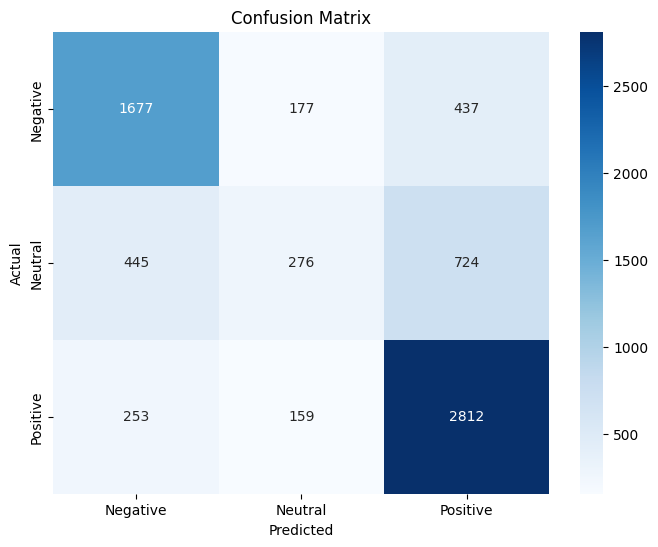

In [11]:
# Compute test metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_f_score = f1_score(test_labels, test_predictions, average="weighted")
test_precision = precision_score(test_labels, test_predictions, average="weighted")
test_recall = recall_score(test_labels, test_predictions, average="weighted")

# Display the final test metrics
print(f"Test Accuracy: {test_accuracy:.4f}, F Score: {test_f_score:.4f}")
print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix:")
print(cm)

# Visualizing the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()